In [17]:
import numpy as np
import random
from decimal import Decimal
from functools import lru_cache

FIELD_SIZE = 257

@lru_cache(None)
def reconstruct_secret(shares_tuple):
    shares = list(shares_tuple)
    sums = 0
    for j, (xj, yj) in enumerate(shares):
        prod = Decimal(1)
        for i, (xi, _) in enumerate(shares):
            if i != j:
                prod *= Decimal(Decimal(xi) / (xi - xj))
        sums += Decimal(prod * yj)
    return int(round(Decimal(sums), 0)) % FIELD_SIZE

@lru_cache(None)
def polynom(x, coefficients_tuple):
    coefficients = list(coefficients_tuple)
    point = sum((x ** i) * coef for i, coef in enumerate(coefficients[::-1]))
    return point % FIELD_SIZE

@lru_cache(None)
def coeff(t, secret):
    return tuple([random.randint(0, FIELD_SIZE - 1) for _ in range(t - 1)] + [secret])

def generate_shares(n, m, image):
    flat_image = image.flatten().astype(int)
    shares_list = [[] for _ in range(n)]

    for pixel in flat_image:
        coefficients = coeff(m, pixel)
        pixel_shares = [(x, polynom(x, coefficients)) for x in range(1, n + 1)]
        for i in range(n):
            shares_list[i].append(pixel_shares[i])

    return shares_list, image.shape

def reconstruct_image(shares, shape, threshold):
    recovered_pixels = [
        reconstruct_secret(tuple(shares[j][i] for j in range(threshold))) 
        for i in range(len(shares[0]))
    ]
    recovered_image = np.array(recovered_pixels).reshape(shape)
    return np.clip(recovered_image, 0, 255).astype(np.uint8)


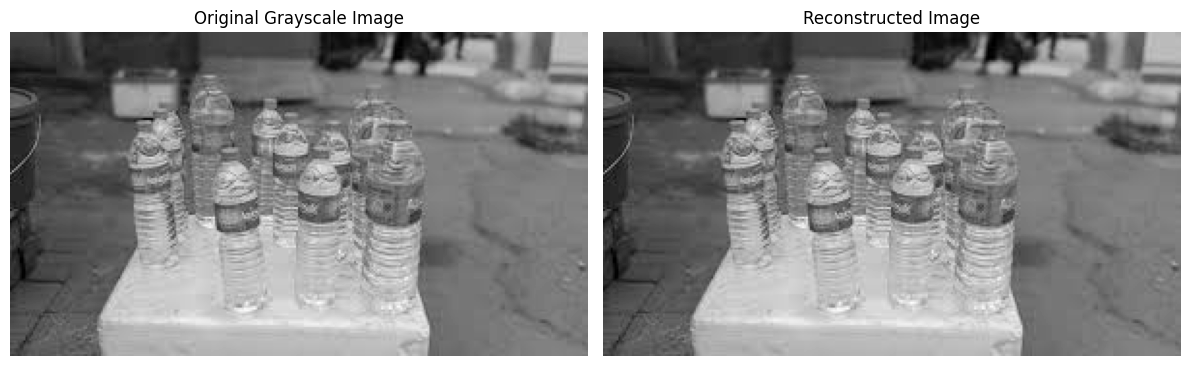

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "/kaggle/input/imagesss/bisleri_2.jpeg"
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

n = 5 
m = 3  
shares, shape = generate_shares(n, m, original_image)

share1_pixels = [y for _, y in shares[0]]
share1_image = np.array(share1_pixels).reshape(shape)

reconstructed_image = reconstruct_image(shares[:m], shape, m)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(original_image, cmap="gray")
axes[0].set_title("Original Grayscale Image")
axes[0].axis("off")

axes[1].imshow(reconstructed_image, cmap="gray")
axes[1].set_title("Reconstructed Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()
